In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using StatsBase
using Random
using Printf
using Dates
using Optim
using DataFrames, CSV

  Activating project at `~/Documents/Github/DriftDiffusionModels.jl`
Precompiling project...
    880.3 ms  ✓ DriftDiffusionModels
  1 dependency successfully precompiled in 2 seconds. 101 already precompiled.


In [2]:
mouse_df = CSV.read("mouse_df.csv", DataFrame)

countmap(mouse_df[!, :name])

filtered_df = mouse_df[mouse_df.:name .== "MABL6-9", :]

Row,name,session_datetime,trial,trial_datetime,task,stage,choice,outcome,rt,init_time,correct_side,lambda_left,lambda_right,flash_bins,flashes_left,flashes_right,reward,training_criterion,label,specie,sex,subid,level
,String15,String31,Int64,String31,String7,Int64,String7,String7,Float64,Float64,String7,Float64,Float64,Int64,Float64,Float64,Int64,Float64,Missing,String7,String7,Missing,Missing
1,MABL6-9,2022-08-19 10:08:50,1,2022-08-19 10:08:50,rate,5,left,correct,0.2716,8.6378,left,0.8,-100.0,2,11.0,0.0,5,0.002,missing,Mouse,Male,missing,missing
2,MABL6-9,2022-08-19 10:08:50,2,2022-08-19 10:09:04,rate,5,left,error,0.4124,12.7291,right,-100.0,0.8,4,0.0,1111.0,5,0.002,missing,Mouse,Male,missing,missing
3,MABL6-9,2022-08-19 10:08:50,3,2022-08-19 10:09:25,rate,5,left,correct,0.2669,2.4767,left,0.8,-100.0,2,11.0,0.0,5,0.004,missing,Mouse,Male,missing,missing
4,MABL6-9,2022-08-19 10:08:50,4,2022-08-19 10:09:33,rate,5,right,correct,0.8428,1.4196,right,-100.0,0.8,8,10.0,1.11111e7,5,0.006,missing,Mouse,Male,missing,missing
5,MABL6-9,2022-08-19 10:08:50,5,2022-08-19 10:09:41,rate,5,right,correct,0.3541,0.2732,right,-100.0,0.8,3,10.0,101.0,5,0.008,missing,Mouse,Male,missing,missing
6,MABL6-9,2022-08-19 10:08:50,6,2022-08-19 10:09:46,rate,5,left,correct,0.247,2.3272,left,0.8,-100.0,2,11.0,0.0,5,0.01,missing,Mouse,Male,missing,missing
7,MABL6-9,2022-08-19 10:08:50,7,2022-08-19 10:09:54,rate,5,left,correct,0.4099,1.0008,left,0.8,-100.0,4,1101.0,10.0,5,0.012,missing,Mouse,Male,missing,missing
8,MABL6-9,2022-08-19 10:08:50,8,2022-08-19 10:10:01,rate,5,right,error,0.2372,6.1579,left,0.8,-100.0,2,11.0,0.0,5,0.012,missing,Mouse,Male,missing,missing
9,MABL6-9,2022-08-19 10:08:50,9,2022-08-19 10:10:15,rate,5,left,error,0.3275,0.8614,right,-100.0,0.8,3,101.0,10.0,5,0.012,missing,Mouse,Male,missing,missing


In [3]:
# Map correct -> 1 and incorrect -> -1 (only for error and correct, omissions are gone)
numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in filtered_df.outcome]

# Get reaction times, filter out "NAN" values
valid_rt_indices = findall(rt -> uppercase(string(rt)) != "NAN", filtered_df.rt)

# Apply both filters to keep data aligned
final_df = filtered_df[valid_rt_indices, :]
final_outcomes = numeric_outcomes[valid_rt_indices]

# Convert RTs to Float64
# final_rts = [parse(Float64, rt) for rt in final_df.rt]
final_rts = final_df.rt

# Extract just the date part from the timestamp strings
dates = [Date(split(dt)[1]) for dt in final_df.trial_datetime]

# Get unique dates in chronological order
unique_dates = sort(unique(dates))

# Create a vector of vectors, where each inner vector contains DDMResults for one day
results_by_date = Vector{Vector{DDMResult}}()

for date in unique_dates
    # Get indices for this date
    day_indices = findall(dates .== date)
    
    # Skip days with no valid data
    if isempty(day_indices)
        continue
    end
    
    # Extract RTs and outcomes for this date
    day_rts = final_rts[day_indices]
    day_outcomes = final_outcomes[day_indices]
    
    # Create DDMResult objects for this day
    day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
    
    # Add to our vector of vectors
    push!(results_by_date, day_results)
end

# Now calculate the sequence ends (cumulative sum of lengths)
seq_ends = cumsum([length(seq) for seq in results_by_date])

# Concatenate all results into a single vector
all_results = reduce(vcat, results_by_date)

12311-element Vector{DDMResult}:
 DDMResult(0.2716, 1)
 DDMResult(0.4124, -1)
 DDMResult(0.2669, 1)
 DDMResult(0.8428, 1)
 DDMResult(0.3541, 1)
 DDMResult(0.247, 1)
 DDMResult(0.4099, 1)
 DDMResult(0.2372, -1)
 DDMResult(0.3275, -1)
 DDMResult(0.2344, 1)
 DDMResult(0.2164, 1)
 DDMResult(0.3141, -1)
 DDMResult(0.3099, 1)
 ⋮
 DDMResult(0.272, 1)
 DDMResult(0.3076, -1)
 DDMResult(0.2237, 1)
 DDMResult(0.4864, 1)
 DDMResult(0.2847, -1)
 DDMResult(0.2424, 1)
 DDMResult(0.4899, -1)
 DDMResult(0.226, -1)
 DDMResult(0.2562, -1)
 DDMResult(0.5747, 1)
 DDMResult(0.3208, 1)
 DDMResult(0.4196, 1)

In [12]:
true_trans = [0.9 0.1 0.0; 
              0.05 0.9 0.05;
              0.99  0.0099 0.0001]
true_init = [0.66, 0.24, 0.1]

B₀ = 2
v₀ = 1.7
a₀ = 0.5
τ₀ = 0.3

B₁ = 1.75
v₁ = 1.0
a₁ = 0.5
τ₁ = 0.3

DDM1 = DriftDiffusionModel(B₀, v₀, a₀, τ₀, 1.0)
DDM2 = DriftDiffusionModel(B₁, v₁, a₁, τ₁, 1.0)
λ = 1

Exp = ExponentialEmission(λ)

dists_true = [DDM1, DDM2, Exp]

3-element Vector{EmissionModel}:
 DriftDiffusionModel(2.0, 1.7, 0.5, 0.3, 1.0)
 DriftDiffusionModel(1.75, 1.0, 0.5, 0.3, 1.0)
 ExponentialEmission(1.0)

In [19]:
hmm = HMM(true_init, true_trans, dists_true)
control_seq = fill(nothing, length(all_results))
seq_ends = [length(all_results)] 
hmm_est, loglikelihood_evolution = baum_welch(hmm, all_results, control_seq; max_iterations=100, loglikelihood_increasing=false)

(Hidden Markov Model with:
 - initialization: [6.026546056130964e-79, 0.9997580005046888, 0.00024199949531120753]
 - transition matrix: [0.9471655338643467 0.052834466135653305 0.0; 0.011532928345576612 0.7867662939817076 0.20170077767271585; 0.10782661812988353 0.5625071371959804 0.32966624467413597]
 - observation distributions: [DriftDiffusionModel(0.9394452190140726, 1.043085551216806, 0.5, 0.21964433315172524, 1.0), DriftDiffusionModel(0.6911395932260498, 0.6470694204250339, 0.5, 0.18741993777009402, 1.0), ExponentialEmission(0.7915580785770062)], [-64001.26690895951, -14310.020691070567, -9652.56905953457, -8156.726329394413, -7356.546284388108, -6792.817266424917, -6256.668461820742, -5701.568095233655, -5135.039668529895, -4588.13339254757  …  301.9520860122298, 301.9691188391699, 301.99926941656986, 302.10758034374885, 302.496980925021, 303.22436693127383, 303.7247802045082, 303.85818818287896, 303.8728465622321, 303.8678391633736])

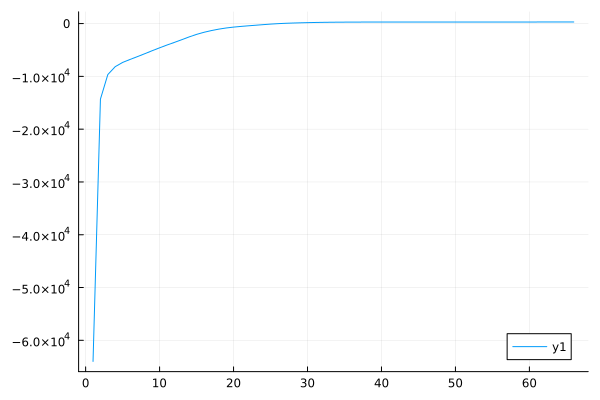

In [20]:
plot(loglikelihood_evolution)

In [21]:
println("=== Initialization Probabilities ===")
println("Recovered: ", round.(hmm_est.init, sigdigits=4))
println()

println("=== Transition Matrix ===")
println("Recovered:")
display(round.(hmm_est.trans, sigdigits=4))
println()

println("=== Observation Distributions ===")
for (i, est_dist) in enumerate(hmm_est.dists)
    println("State $i:")
    if est_dist isa DriftDiffusionModel
        @printf("  B   => Recovered: %-8.4f\n", est_dist.B)
        @printf("  v   => Recovered: %-8.4f\n", est_dist.v)
        @printf("  a₀  => Recovered: %-8.4f\n", est_dist.a₀)
        @printf("  τ   => Recovered: %-8.4f\n", est_dist.τ)
        @printf("  σ   => Recovered: %-8.4f\n", est_dist.σ)
    elseif est_dist isa ExponentialEmission
        @printf("  b   => Recovered: %-8.4f", est_dist.λ)
    end
end

=== Initialization Probabilities ===
Recovered: [6.027000000000001e-79, 0.9998, 0.000242]

=== Transition Matrix ===
Recovered:


3×3 Matrix{Float64}:
 0.9472   0.05283  0.0
 0.01153  0.7868   0.2017
 0.1078   0.5625   0.3297


=== Observation Distributions ===
State 1:
  B   => Recovered: 0.9394  
  v   => Recovered: 1.0431  
  a₀  => Recovered: 0.5000  
  τ   => Recovered: 0.2196  
  σ   => Recovered: 1.0000  
State 2:
  B   => Recovered: 0.6911  
  v   => Recovered: 0.6471  
  a₀  => Recovered: 0.5000  
  τ   => Recovered: 0.1874  
  σ   => Recovered: 1.0000  
State 3:
  b   => Recovered: 0.7916  

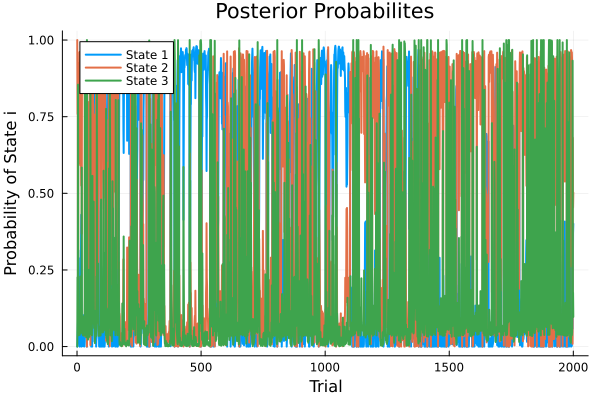

In [24]:
# get the posterior distribution of the hidden states
posterior = forward(hmm_est, all_results; seq_ends=seq_ends)
γ = posterior[1]

plot(γ[1, 1:2000], title="Posterior Probabilites", xlabel="Trial", ylabel="Probability of State i", label="State 1", linewidth=2)
plot!(γ[2, 1:2000], label="State 2", linewidth=2)
plot!(γ[3, 1:2000], label="State 3", linewidth=2)

In [43]:
rts = [d.rt for d in all_results] 

x = range(minimum(rts), stop=2, length=12311)

dist = hmm_est.dists[1]
pdf_vals = [exp(logdensityof(dist, DDMResult(rt, 1))) for rt in x]
weighted_pdf = γ[1,:] .* pdf_vals

maximum(weighted_pdf)

3.148768027702022

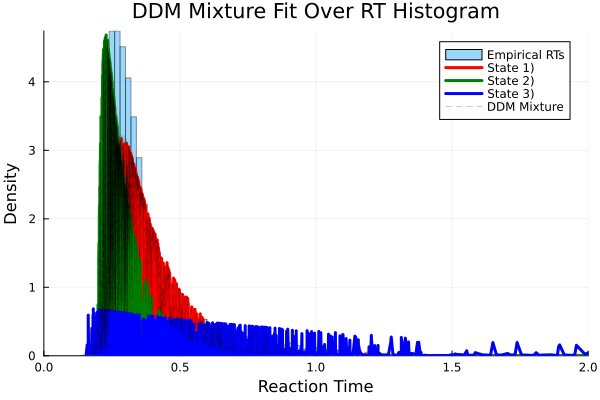

In [46]:
function plot_ddm_mixture_fit(rt_data::Vector{Float64},
                              hmm_est::HMM;
                              n_bins::Int=400,
                              title::String="DDM Mixture Fit Over RT Histogram")

    k = length(hmm_est.dists)  # number of states
    colors = [:red, :green, :blue]

    # Build histogram
    p = histogram(
        rt_data;
        bins=n_bins,
        normalize=true,
        alpha=0.4,
        label="Empirical RTs",
        xlabel="Reaction Time",
        ylabel="Density",
        title=title,
    )

    # Plot weighted densities for each state
    for i in 1:k
        dist = hmm_est.dists[i]
        pdf_vals = [exp(logdensityof(dist, DDMResult(rt, 1))) for rt in rt_data]
        weighted_pdf = γ[i,:] .* pdf_vals
        plot!(
            p, rt_data, weighted_pdf;
            lw=3,
            color=colors[i],
            label="State $i)",
        )
    end

    # Plot full mixture
    mix_pdf = zeros(length(rt_data))
    for i in 1:k
        dist = hmm_est.dists[i]
        mix_pdf .+= γ[i,:] .* [exp(logdensityof(dist, DDMResult(rt, 1))) for rt in rt_data]
    end

    plot!(
        p, rt_data, mix_pdf;
        lw=0.05,
        ls=:dash,
        color=:black,
        label="DDM Mixture",
    )

    xlims!(0,2)

    return p
end

rts = [d.rt for d in all_results] 

sort!(rts)

plot_ddm_mixture_fit(rts, hmm_est)


In [47]:
# plot simulated data from model over the true data to test goodness of fit 

In [9]:
function state_dependent_histogram(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                   simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                   n_states::Int=3;
                                   n_bins::Int=100)

    true_results, true_states = true_data
    sim_results, sim_states = simulated_data

    # Determine all reaction times to calculate bin edges
    all_rts = [r.rt for r in true_results] ∪ [r.rt for r in sim_results]
    min_rt, max_rt = extrema(all_rts)
    bin_edges = range(min_rt, max_rt; length=n_bins+1)
    bin_width = step(bin_edges)
    bin_centers = collect(bin_edges[1:end-1] .+ bin_width/2)

    # Utility: Compute normalized histogram heights
    function compute_hist_heights(data)
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        heights = hist.weights ./ (sum(hist.weights) * bin_width)
        return heights
    end

    # Create a plot for each state
    state_plots = []

    for state in 1:n_states
        # Get indices for each state
        true_idx = findall(==(state), true_states)
        sim_idx = findall(==(state), sim_states)

        true_correct = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == 1]
        true_error   = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == -1]
        sim_correct  = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx && r.choice == 1]
        sim_error    = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx && r.choice == -1]

        if isempty(true_correct) && isempty(true_error) && isempty(sim_correct) && isempty(sim_error)
            push!(state_plots, plot(title="State $state: No data", size=(1100, 250)))
            continue
        end

        # Compute heights
        tc_h = compute_hist_heights(true_correct)
        te_h = compute_hist_heights(true_error)
        sc_h = compute_hist_heights(sim_correct)
        se_h = compute_hist_heights(sim_error)

        # Start a new plot for this state
        p = plot(title="State $state Response Times", xlabel="RT (s)", ylabel="Density")

        # Positive bars for correct
        bar!(p, bin_centers, tc_h, label="True Data (Correct)", alpha=0.8, color=:blue, bar_width=bin_width)
        bar!(p, bin_centers, sc_h, label="Simulated Data (Correct)", alpha=0.6, color=:lightblue, bar_width=bin_width)

        # Negative bars for error
        bar!(p, bin_centers, -te_h, label="True Data (Error)", alpha=0.8, color=:red, bar_width=bin_width)
        bar!(p, bin_centers, -se_h, label="Simulated Data (Error)", alpha=0.6, color=:pink, bar_width=bin_width)

        # Horizontal zero line
        hline!(p, [0], color=:black, linestyle=:dash, label=nothing)

        # Symmetric y-ticks with formatting
        max_y = maximum(abs.([maximum(tc_h), maximum(sc_h), maximum(te_h), maximum(se_h)]))
        y_ticks = range(-max_y, max_y; length=7)
        yticks!(p, y_ticks, [@sprintf("%.2f", abs(y)) for y in y_ticks])

        push!(state_plots, p)
    end

    # Combine vertically
    return plot(state_plots..., layout=(n_states, 1), size=(1100, 300 * n_states), legend=:topright)
end

state_dependent_histogram((obs_seq_true, z_true), (obs_seq_sim, z_sim), 3)

LoadError: UndefVarError: `obs_seq_true` not defined in `Main`
Suggestion: check for spelling errors or missing imports.